# house price prediction

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.externals import joblib 
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

import scipy.stats as stats
from scipy.stats import norm ,rankdata

from scipy.special import boxcox1p
from scipy.stats import normaltest
import statsmodels
import statsmodels.api as sm
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer


from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

In [289]:
df = pd.read_csv("housing_train.csv")
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


In [290]:
print("Data Shape: "+str(df.shape))
print()
print("Columns: "+str(df.columns))
print()
print(df.info())

Data Shape: (265190, 22)

Columns: Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
id                         265190 non-null int64
url                        265190 non-null object
region                     265190 non-null object
region_url                 265190 non-null object
price                      265190 non-null int64
type                       265190 non-null object
sqfeet                     265190 non-null int64
beds                       265190 non-null int64
baths                      265190 non-null float64
cats_allowed               265190 non-null int64
dogs_allow

### Missing value counts

In [297]:
df.isnull().sum()

id                             0
url                            0
region                         0
region_url                     0
price                          0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options                0
parking_options            95135
image_url                      0
description                    2
lat                         1419
long                        1419
state                          1
dtype: int64

## 3- Region

## 2- Url

In [230]:
df.url[0]

'https://bham.craigslist.org/apa/d/birmingham-huge-three-bedroom-among-the/7039061606.html'

In [231]:
from urllib.parse import urlparse, parse_qs
from tqdm import tqdm
disc = {"url_parsed_loc": [], "url_params":[], "url_path_components": []}

for i in tqdm(range(df.shape[0]), position=0, leave=True):
    parsed = urlparse(df.url[i])
    disc["url_parsed_loc"].append(parsed.netloc)
    
    params = parse_qs(parsed.query)
    disc["url_params"].append(params)
    
    path_components = list(filter(bool, parsed.path.split('/')))
    disc["url_path_components"].append(path_components)

100%|███████████████████████████████████████████████████████████████████████| 265190/265190 [00:09<00:00, 26934.19it/s]


In [232]:
url_df = pd.DataFrame(disc)
print(url_df.url_params.value_counts())
url_df.head()

{}    265190
Name: url_params, dtype: int64


,url_parsed_loc,url_params,url_path_components
0,bham.craigslist.org,{},"[apa, d, birmingham-huge-three-bedroom-among-t..."
1,bham.craigslist.org,{},"[apa, d, birmingham-window-covering-dishwasher..."
2,bham.craigslist.org,{},"[apa, d, birmingham-garages-for-rent-at-100, 7..."
3,bham.craigslist.org,{},"[apa, d, birmingham-find-you-way-find-you-home..."
4,bham.craigslist.org,{},"[apa, d, birmingham-2-sparkling-swimming-pool-..."


In [233]:
url_df.drop("url_params", axis=1, inplace=True)
url_df.head()

,url_parsed_loc,url_path_components
0,bham.craigslist.org,"[apa, d, birmingham-huge-three-bedroom-among-t..."
1,bham.craigslist.org,"[apa, d, birmingham-window-covering-dishwasher..."
2,bham.craigslist.org,"[apa, d, birmingham-garages-for-rent-at-100, 7..."
3,bham.craigslist.org,"[apa, d, birmingham-find-you-way-find-you-home..."
4,bham.craigslist.org,"[apa, d, birmingham-2-sparkling-swimming-pool-..."


In [234]:
cnt=0
for i in tqdm(range(df.shape[0]), position=0, leave=True):
    if df["region_url"][i].find(url_df["url_parsed_loc"][i]) >= 0: 
        cnt+=1

print("Count: "+str(cnt))
print("Error rate: "+str(1-(cnt/df.shape[0])))

100%|███████████████████████████████████████████████████████████████████████| 265190/265190 [00:07<00:00, 34037.04it/s]


Count: 264783
Error rate: 0.0015347486707643077


In [238]:
#TODO: remove the useless colums here

## 16- Laundry Options

### Model based imputation (filling missing values)

In [292]:
#before imputation
print(df["laundry_options"].value_counts())
print(df["laundry_options"].isna().sum())

w/d in unit           91074
w/d hookups           50252
laundry on site       39186
laundry in bldg       27816
no laundry on site     2551
Name: laundry_options, dtype: int64
54311


In [293]:
from sklearn.neighbors import KNeighborsClassifier
decide_cols = ["beds", "baths", "cats_allowed", "dogs_allowed", 
               "smoking_allowed", "wheelchair_access", "electric_vehicle_charge",
               "comes_furnished", "price" ]

X_train = df[decide_cols][df["laundry_options"].isna()==False]
y_train = df["laundry_options"][df["laundry_options"].isna()==False]
X_test = df[decide_cols][df["laundry_options"].isna()==True]
 
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
laundry_pred = neigh.predict(X_test)
print(laundry_pred)
print(laundry_pred.size)

# filling missing values
df["laundry_options"][df["laundry_options"].isna()==True] = laundry_pred

['w/d in unit' 'w/d hookups' 'w/d in unit' ... 'laundry in bldg'
 'laundry on site' 'w/d in unit']
54311


In [294]:
print(df["laundry_options"].value_counts())
print(df["laundry_options"].isna().sum())

w/d in unit           112525
w/d hookups            64303
laundry on site        50051
laundry in bldg        35417
no laundry on site      2894
Name: laundry_options, dtype: int64
0


In [295]:
laundry_df = pd.get_dummies(df.laundry_options, prefix="laundry")
print(laundry_df.shape)
laundry_df.head()

(265190, 5)


,laundry_laundry in bldg,laundry_laundry on site,laundry_no laundry on site,laundry_w/d hookups,laundry_w/d in unit
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [298]:
#TODO: add data to table

## 17- Parking Options

## 20, 21- Latitude and Longitude

In [181]:
df.dropna(inplace=True)
df.shape

In [183]:
from sklearn.cluster import KMeans

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  5.65s/it]


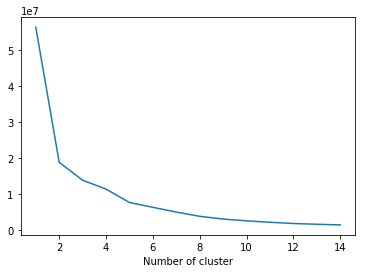

In [212]:
from sklearn.cluster import KMeans

sse={}
lat_long_df = df[['lat', 'long']]

for k in tqdm(range(1, 15), position=0, leave=True):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(lat_long_df)
    lat_long_df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [223]:
kmeans = KMeans(n_clusters=12, random_state=0)

v = kmeans.fit_predict(df[["lat", "long"]])
print(kmeans.labels_)
print(v.size)

[10 10 10 ...  9  9  9]
164283


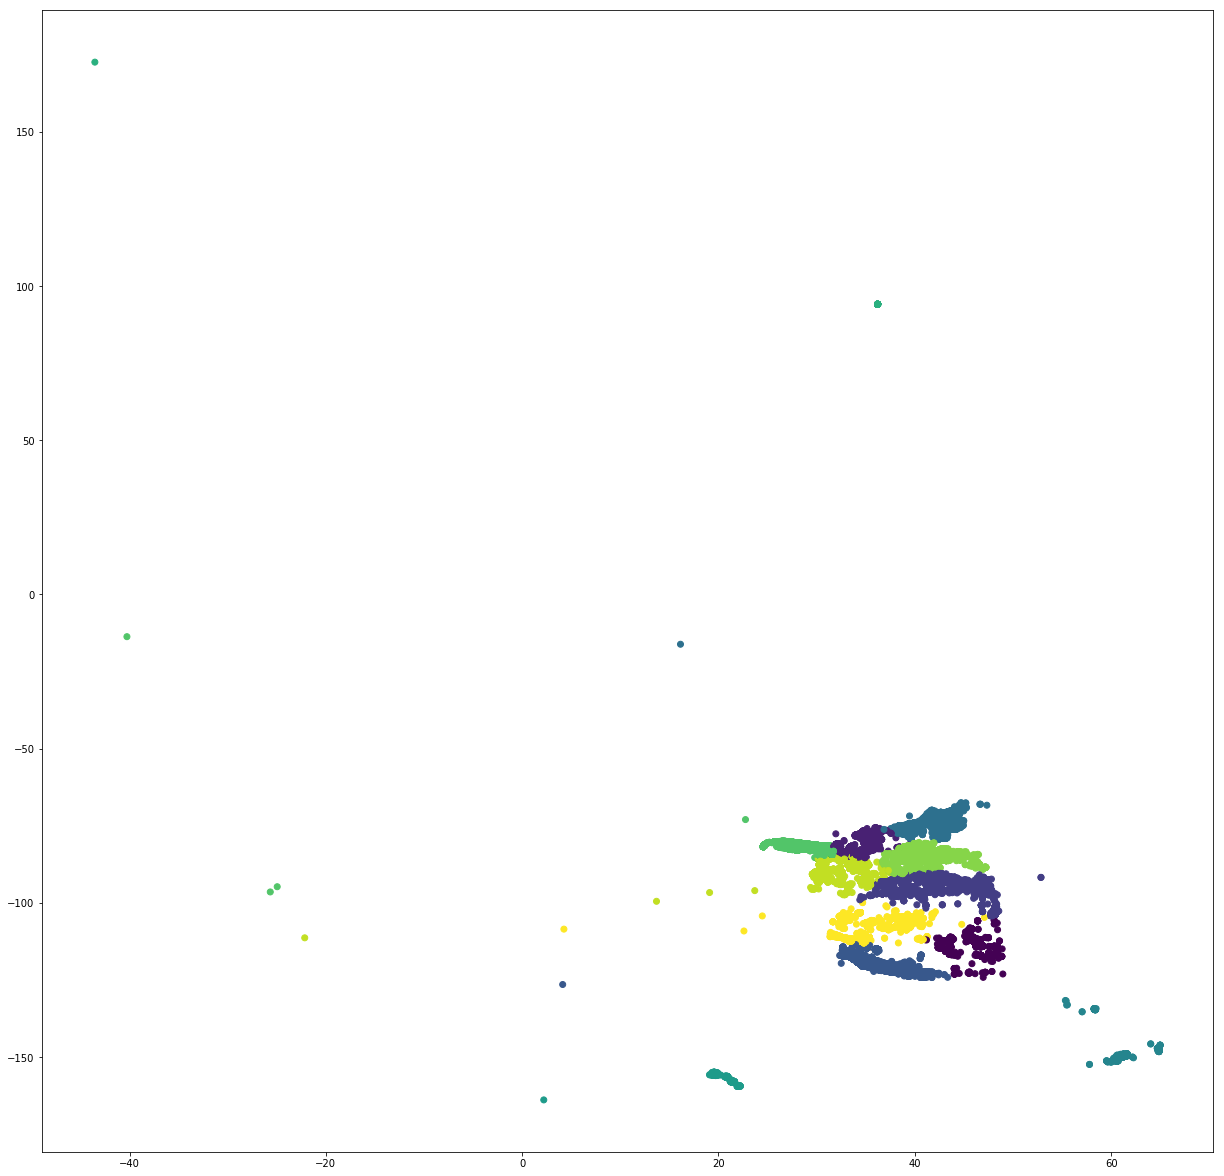

In [224]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(21,21))
plt.scatter(x=df['lat'], y=df['long'], c=v)
plt.show()

In [225]:
#TODO: add data to table

## 19- Description

In [235]:
i=114
print(df.url[i])
print(df.description[i])

https://bham.craigslist.org/apa/d/birmingham-handrails-faux-hardwood/7036605437.html
Apartments In Birmingham AL Welcome to 100 Inverness Apartment Homes, a luxury apartment community tucked away into one of the most coveted locations in the city for Birmingham apartments. Find stylish one-, two-, and three-bedroom apartment floor plans tailored to your wants and needs, complete with the amenities that are important to you. Our layouts come with just enough variety to enable you to make it your own haven unlike any other. Get inspired by our photos and the serenity of the nature surrounding you to let your aesthetic come together with our stylish, modern designs for a home you wonât be able to wait to show off to your guests. Even beyond style, our pet-friendly apartment community is also all about functionality! Some of our homes come with washer and dryer hookups, wood burning fireplaces, hardwood floors, and a private patio or balcony. All of our residents can make use of oversize

In [236]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sid_obj = SentimentIntensityAnalyzer()

description_dict = {"description_negative":[], "description_neutral": [], "description_positive":[]}

# loop = df.shape[0]
loop = 1000
for i in tqdm(range(loop), position=0, leave=True):
    desc = df.description[i]
    sentiment_dict = sid_obj.polarity_scores(desc) 
    description_dict["description_negative"].append(sentiment_dict["neg"])
    description_dict["description_neutral"].append(sentiment_dict["neu"])
    description_dict["description_positive"].append(sentiment_dict["pos"])

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 357.17it/s]


In [237]:
desc_df = pd.DataFrame(description_dict)
print(desc_df.shape)
desc_df.head()

(1000, 3)


,description_negative,description_neutral,description_positive
0,0.005,0.875,0.120
1,0.000,0.771,0.229
2,0.005,0.876,0.119
3,0.005,0.875,0.120
4,0.005,0.888,0.107
